In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [19]:
train_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
test_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

train_df.columns = ['Tweet ID','Entity','Sentiment','Tweet content']
test_df.columns = ['Tweet ID','Entity','Sentiment','Tweet content']

In [20]:
train_df.Sentiment.value_counts()

Sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [21]:
train_df.tail()

,Tweet ID,Entity,Sentiment,Tweet content
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...
74680,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [22]:
test_df.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [23]:
train_df = train_df.convert_dtypes()
test_df = test_df.convert_dtypes()

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       74681 non-null  Int64 
 1   Entity         74681 non-null  string
 2   Sentiment      74681 non-null  string
 3   Tweet content  73995 non-null  string
dtypes: Int64(1), string(3)
memory usage: 2.4 MB


In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       999 non-null    Int64 
 1   Entity         999 non-null    string
 2   Sentiment      999 non-null    string
 3   Tweet content  999 non-null    string
dtypes: Int64(1), string(3)
memory usage: 32.3 KB


In [26]:
train_df.describe()

,Tweet ID
count,74681.0
mean,6432.640149
std,3740.423819
min,1.0
25%,3195.0
50%,6422.0
75%,9601.0
max,13200.0


In [27]:
test_df.describe()

,Tweet ID
count,999.0
mean,6435.159159
std,3728.912226
min,6.0
25%,3241.5
50%,6560.0
75%,9662.5
max,13197.0


In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import re
from collections import Counter
from torch.optim import Adam
import matplotlib.pyplot as plt

# 1. Data Loading and Cleaning
def load_and_clean_data():
    train_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
    test_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')
    
    train_df.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet content']
    test_df.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet content']
    
    train_df = train_df.convert_dtypes()
    test_df = test_df.convert_dtypes()
    
    train_df = train_df.dropna(subset=['Tweet content'])
    test_df = test_df.dropna(subset=['Tweet content'])
    
    return train_df, test_df

In [29]:
# 2. Text Preprocessing
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

In [30]:
# 3. Vocabulary Building
def build_vocab(texts, min_freq=2):
    word_freq = Counter()
    for text in texts:
        words = clean_text(text).split()
        word_freq.update(words)
    
    vocab = {word: idx + 2 for idx, (word, freq) in enumerate(word_freq.items()) if freq >= min_freq}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

In [31]:
# 4. Text to Indices Conversion
def text_to_indices(text, vocab, max_len=50):
    words = clean_text(text).split()
    indices = [vocab.get(word, vocab['<UNK>']) for word in words[:max_len]]
    if len(indices) < max_len:
        indices += [vocab['<PAD>']] * (max_len - len(indices))
    vocab_size = len(vocab)
    indices = [min(idx, vocab_size - 1) for idx in indices]
    return indices

In [32]:
# 5. Custom Dataset
class TwitterDataset(Dataset):
    def __init__(self, df, vocab, max_len=50):
        self.tweets = df['Tweet content'].values
        self.labels = df['Sentiment'].values
        self.vocab = vocab
        self.max_len = max_len
        self.vocab_size = len(vocab)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, idx):
        text = self.tweets[idx]
        label = self.labels[idx]
        
        indices = text_to_indices(text, self.vocab, self.max_len)
        indices = [min(idx, self.vocab_size - 1) for idx in indices]
        
        return {
            'input_ids': torch.tensor(indices, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [33]:
# 6. Data Preparation with Train-Val Split
def prepare_data(train_df, test_df, batch_size=32, val_split=0.2):
    # Split train_df into train and validation
    train_data, val_data = train_test_split(train_df, test_size=val_split, random_state=42)
    
    # Build vocabulary from training data only
    vocab = build_vocab(train_data['Tweet content'])
    
    # Create datasets
    train_dataset = TwitterDataset(train_data, vocab)
    val_dataset = TwitterDataset(val_data, vocab)
    test_dataset = TwitterDataset(test_df, vocab)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, vocab, train_dataset.label_encoder

In [34]:
# 7. Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        return output

In [35]:
# 8. Training Function with Metrics Tracking
def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss = total_loss / len(train_loader)
        train_accuracy = accuracy_score(all_labels, all_preds)
        
        val_loss, val_accuracy, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        print('---')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [36]:
# 9. Evaluation Function with Additional Metrics
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            probs = nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy, all_labels, all_preds, all_probs

In [37]:
# 10. Plotting Function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [38]:
# 11. ROC Curve Plotting
def plot_roc_curve(true_labels, pred_probs, num_classes, label_encoder):
    plt.figure(figsize=(8, 6))
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(np.array(true_labels) == i, [p[i] for p in pred_probs])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test Set)')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
# 12. Prediction Function
def predict_sentiment(text, model, vocab, label_encoder, device, max_len=50):
    model.eval()
    indices = text_to_indices(text, vocab, max_len)
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1)
        sentiment = label_encoder.inverse_transform(prediction.cpu().numpy())[0]
    
    return sentiment

Using device: cuda
Vocabulary size: 23583
Number of classes: 4
Training samples: 59196
Validation samples: 14799
Test samples: 999
Epoch 1/10:
Train Loss: 1.3615, Train Accuracy: 0.3103
Val Loss: 1.2940, Val Accuracy: 0.3943
---
Epoch 2/10:
Train Loss: 1.1341, Train Accuracy: 0.5192
Val Loss: 1.0044, Val Accuracy: 0.5900
---
Epoch 3/10:
Train Loss: 0.8497, Train Accuracy: 0.6706
Val Loss: 0.8392, Val Accuracy: 0.6762
---
Epoch 4/10:
Train Loss: 0.6184, Train Accuracy: 0.7732
Val Loss: 0.7389, Val Accuracy: 0.7316
---
Epoch 5/10:
Train Loss: 0.4557, Train Accuracy: 0.8377
Val Loss: 0.6901, Val Accuracy: 0.7622
---
Epoch 6/10:
Train Loss: 0.3493, Train Accuracy: 0.8776
Val Loss: 0.6408, Val Accuracy: 0.7816
---
Epoch 7/10:
Train Loss: 0.2809, Train Accuracy: 0.9020
Val Loss: 0.6367, Val Accuracy: 0.7885
---
Epoch 8/10:
Train Loss: 0.2372, Train Accuracy: 0.9169
Val Loss: 0.6210, Val Accuracy: 0.7992
---
Epoch 9/10:
Train Loss: 0.2060, Train Accuracy: 0.9281
Val Loss: 0.6534, Val Accuracy

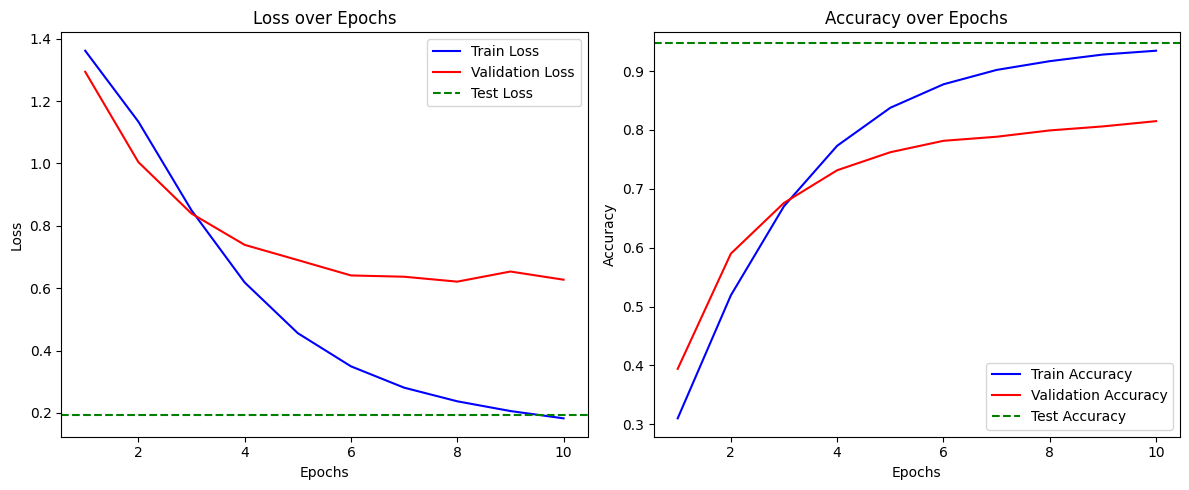

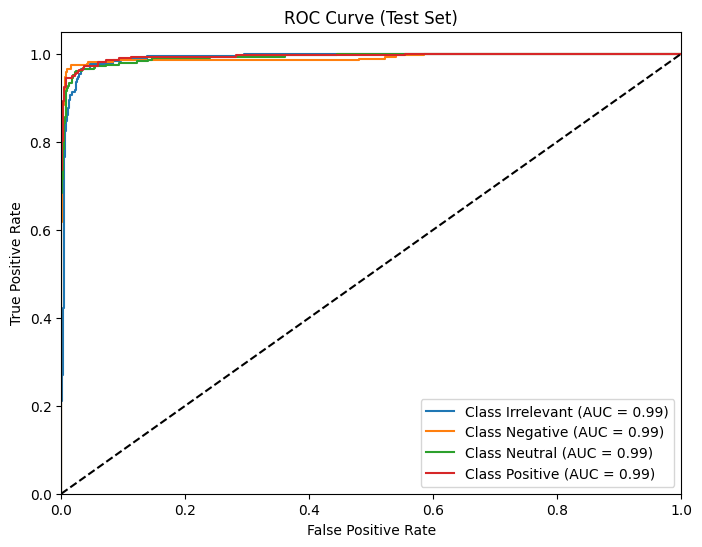


Sample prediction:
Text: I love the new features in this product!
Predicted sentiment: Positive


In [40]:
# 13. Main Execution
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    train_df, test_df = load_and_clean_data()
    
    # Prepare data with train-val split
    train_loader, val_loader, test_loader, vocab, label_encoder = prepare_data(
        train_df, test_df, batch_size=32, val_split=0.2
    )
    
    vocab_size = len(vocab)
    embedding_dim = 100
    hidden_dim = 128
    num_classes = len(label_encoder.classes_)
    
    model = SentimentClassifier(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_classes=num_classes
    ).to(device)
    
    print(f"Vocabulary size: {vocab_size}")
    print(f"Number of classes: {num_classes}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")
    
    # Train model
    num_epochs = 10
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs, device
    )
    
    # Evaluate on test set
    test_loss, test_accuracy, test_labels, test_preds, test_probs = evaluate_model(
        model, test_loader, nn.CrossEntropyLoss(), device
    )
    
    # Calculate additional metrics
    f1 = f1_score(test_labels, test_preds, average='weighted')
    sensitivity = recall_score(test_labels, test_preds, average='weighted')
    
    # Print results
    print('\nFinal Test Metrics:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'F1 Score (weighted): {f1:.4f}')
    print(f'Sensitivity/Recall (weighted): {sensitivity:.4f}')
    print('\nDetailed Classification Report (Test Set):')
    print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))
    
    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy)
    plot_roc_curve(test_labels, test_probs, num_classes, label_encoder)
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab': vocab,
        'label_encoder': label_encoder
    }, 'sentiment_model.pth')
    
    # Sample prediction
    sample_text = "I love the new features in this product!"
    prediction = predict_sentiment(sample_text, model, vocab, label_encoder, device)
    print(f"\nSample prediction:")
    print(f"Text: {sample_text}")
    print(f"Predicted sentiment: {prediction}")
    
    return model, vocab, label_encoder

if __name__ == "__main__":
    try:
        model, vocab, label_encoder = main()
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise